In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import seaborn as sn
import math
import datetime as dt
import geopandas

In [2]:
# Using the 20M rows report
# https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj
df_save = pd.read_csv(r'EMS_Incident_Dispatch_Data.csv')

# Getting rid of all unnecessary columns
df_save = df_save[['INCIDENT_DATETIME', 
                 'FINAL_CALL_TYPE',
                 'FINAL_SEVERITY_LEVEL_CODE',
                 'ZIPCODE']]

# Just to quickly get data back
df = df_save

# Custom csv that maps all report types into the following 6 categories
cats = {0:'Ill',1:'Accident',2:'Mental',3:'Violence/crime',4:'Unknown',5:'Drugs'}
mapping = pd.read_csv(r'C:\Users\Max J. de Bock\Documents\Citadel Data Open\EMS_mapping.csv')
mapping.rename(columns={'Crime:':'crime','Code:':'code','Description:':'description'},inplace=True)
mapping = mapping[['code','crime']]
map_dict = {}

for i in range(len(mapping)):
    map_dict[mapping['code'].iloc[i]] = int(mapping['crime'].iloc[i])
# map_dict format: {'STAB':3,'OD':5, etc....}

C:\Users\Max J. de Bock\Anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,11,17,21,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Extra column with call type now categorized
df = df_save
df['Call_group'] = df['FINAL_CALL_TYPE'].map(map_dict)

# Remove faulty data
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df = df.dropna(axis=0)

# Reformatting
df['Call_group'] = df['Call_group'].astype(int)
df['INCIDENT_DATETIME'] = pd.to_datetime(df['INCIDENT_DATETIME'],format='%m/%d/%Y %I:%M:%S %p')
df['INCIDENT_DATETIME'] = df['INCIDENT_DATETIME'].dt.date
df['INCIDENT_DATETIME'] = [date.year for date in df['INCIDENT_DATETIME']]

# Only using group 'Violence/crime' and 'Drugs'
df = df[(df['Call_group'] == 3)|(df['Call_group'] == 5)]


# The processed version can be found in the data folder 
# under the name 'crime_related_ems_dataframe.csv' ~45MB

# Get list of all zipcodes
all_zipcodes = df['ZIPCODE'].unique()
rpt_type = {v: k for k, v in pd.Series(df['FINAL_CALL_TYPE'].unique()).to_dict().items()}
for j in range(len(all_zipcodes)):
    try:
        all_zipcodes[j] = int(all_zipcodes[j])
    except:
        #Remove the e.g. '23,001' type of entries
        all_zipcodes[j] = int(''.join(filter(lambda i: (i.isdigit() or i == '.'), all_zipcodes[j])))
# Make sure to remove copies
all_zipcodes = list(set(all_zipcodes))

C:\Users\Max J. de Bock\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Max J. de Bock\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Max J. de Bock\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarnin

In [8]:
eligible = pd.read_csv(r'eligible_tracts.csv')['geoid'].values
gentrified = pd.read_csv(r'gentrified_tracts_2018.csv')
gentrified = gentrified[gentrified['gentrified']==1]['geoid'].values

In [16]:
df


,INCIDENT_DATETIME,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,ZIPCODE,Call_group
5,2008,SHOT,3,10457,3
13,2008,DRUG,4,10010,5
16,2008,SHOT,3,11213,3
19,2008,SHOT,3,10457,3
25,2008,SHOT,3,11216,3
...,...,...,...,...,...
20755285,2007,SHOT,3,10457,3
20755288,2007,DRUG,4,11432,5
20755289,2007,DRUG,4,10452,5
20755291,2007,DRUG,4,10452,5


In [6]:
tracts = geopandas.read_file(r'all_census_tracts\pa_2016')[['GEOID','geometry']].set_index('GEOID')
tracts = tracts.append(geopandas.read_file(r'nyc_2016')[['GEOID','geometry']].set_index('GEOID'))
tracts =  tracts.append(geopandas.read_file(r'nj_2016')[['GEOID','geometry']].set_index('GEOID'))
tracts = tracts.append(geopandas.read_file(r'censustracts_newyork_2018')[['GEOID','geometry']].set_index('GEOID'))
tracts = tracts[~tracts.index.duplicated(keep='first')]

In [9]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

geoid_to_zip = {}
zip_to_geoid = {}
print(tracts.index)
i = 0
n = 0
print(len(eligible))
for geoid in eligible:
    if i % 500 == 0:
        print(i)
    i+=1
    try:
        coords = list(tracts.loc[str(geoid)].item().exterior.coords)[0]
        zipcode = search.by_coordinates(coords[1],coords[0], radius=20, returns=1)[0].zipcode
        geoid_to_zip[geoid] = int(zipcode)
        n+=1
        if int(zipcode) in list(zip_to_geoid.keys()):
            zip_to_geoid[int(zipcode)].append(int(geoid))
        else:
            zip_to_geoid[int(zipcode)] = [int(geoid)]
    except:
        print(geoid)
        continue

Index(['42017100102', '42017100103', '42091201411', '42017100104',
       '42017100105', '42017100206', '42017101404', '42101036501',
       '42101000801', '42017105511',
       ...
       '34029731206', '34029736002', '34029738001', '34029738002',
       '34005700402', '34005700503', '34005701102', '34019010300',
       '34005701502', '34029713402'],
      dtype='object', name='GEOID', length=10146)
1530
0
34003023500
34003023600
34013002700
34013002900
34013003000
34013003400
34013005800
34013008500
34017001700
34017002100
34017003300
34017005000
34017005100
34017014500
34017015000
34017015200
34023001806
34023003204
34023005600
34023005900
34023006000
34025804400
34025805002
34029715900
34029720000
34029720201
34029736103
34031175300
34031175400
34031175600
34031175700
34031175800
34031180200
34031180500
500
34031182300
34031183100
34039030300
34039030700
34039030801
34039031600
34039031800
36005001700
36005003600
36005005000
36005005700
36005005901
36005008800
36005009400
360050127

In [10]:
everything = pd.DataFrame()
indexing = []
plt.figure(figsize=(20,10))
data = []
cats = list(rpt_type.keys())
check = 0
tract_set = set()
all_data_dict = {}
for zipcode in list(set(all_zipcodes)):
    if check % 10 == 0:
        print(check)
    temp_df = df[df['ZIPCODE']==zipcode]
    try:
        geoids = zip_to_geoid[int(zipcode)]
        for geoid in geoids:
            year_dict = {}
            for year in range(2005,2021):
                cat_dict = {}
                temp_temp_df = temp_df[temp_df['INCIDENT_DATETIME']==year]
                for cat in cats:
                    cat_dict[cat] = len(temp_temp_df[temp_temp_df['FINAL_CALL_TYPE']==cat])/len(geoids)
                year_dict[year] = cat_dict
            all_data_dict[geoid] = year_dict
    except:
        print(zipcode)
        continue
    check += 1
    
multi_index = pd.DataFrame.from_dict({(i,j): all_data_dict[i][j] 
                           for i in all_data_dict.keys() 
                           for j in all_data_dict[i].keys()},
                       orient='index')

0
10271
0
10279
10280
10281
10282
10803
12345
10302
10308
10309
10314
10
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11370
11371
20
11379
20
11411
11412
11414
11422
30
11426
30
11428
11429
11430
40
10464
10465
50
11001
11004
11005
10000
10001
60
10003
60
10004
60
10005
60
10006
60
10010
10011
10012
10013
10014
11040
10016
10017
10020
10021
10022
10023
10024
70
10033
10036
10040
10041
10044
10045
10048
10055
10065
10075
80
11103
80
11105
10103
10105
10106
10107
10110
10111
10112
10115
10118
10120
10121
10122
10123
10128
10129
10151
10152
10153
10154
11693
10158
10155
11697
10162
11695
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10176
10178
10179
10177
11204
90
11214
11215
11216
100
11222
11228
110
11232
110
11234
11241
11242
11249
11251


<Figure size 1440x720 with 0 Axes>

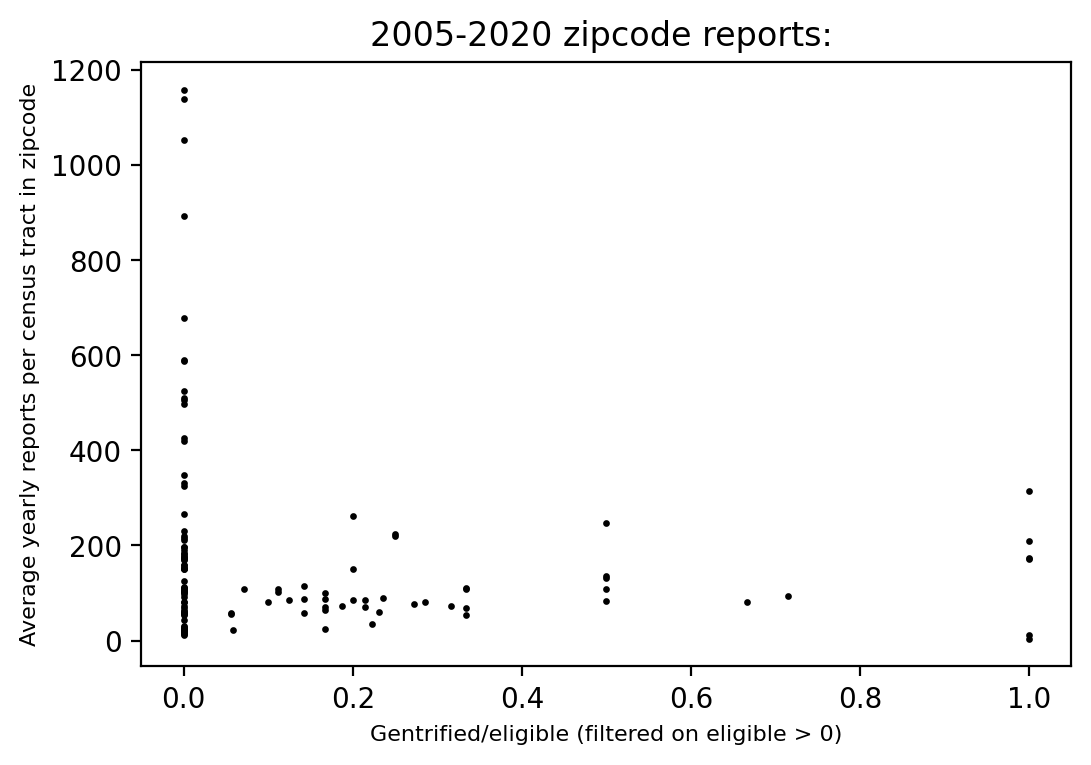

In [15]:
gent_inc = []
matplotlib.rcParams['figure.dpi'] = 200
for zipcode in list(set(all_zipcodes)):
    try:
        geoids = zip_to_geoid[zipcode]
        n = len(geoids)
    except:
        continue

    g = len([geo for geo in geoids if geo in gentrified])
    e = len([geo for geo in geoids if geo in eligible])
    try:
        if e > 0:
            gent_rate = g/e
            inc_rate = len(df[df['ZIPCODE']==zipcode])/n/15
            gent_inc.append([gent_rate,inc_rate])
    except:
        continue

gent, inc = np.stack(gent_inc,axis=0).T
plt.scatter(gent,inc,s=2,c='black')

title = '2005-2020 zipcode reports: '
plt.ylabel('Average yearly reports per census tract in zipcode', fontsize=8)
plt.xlabel('Gentrified/eligible (filtered on eligible > 0)', fontsize=8)
plt.title(title)
plt.show()

C:\Users\Max J. de Bock\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


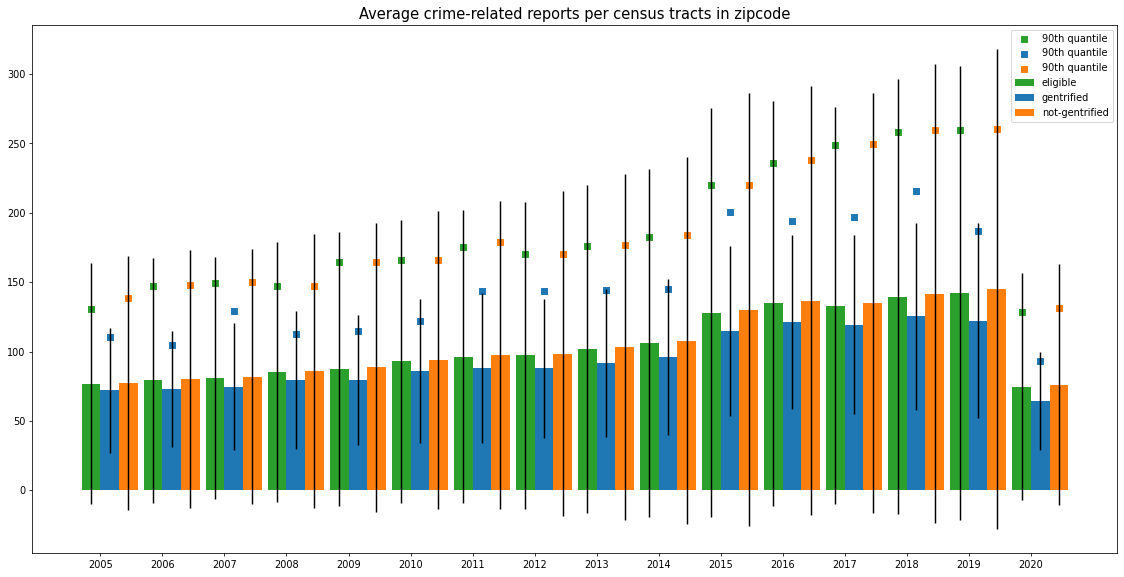

In [12]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 70
colors = ['#2ca02c','#1f77b4', "#ff7f0e"]
bar_colors = ['lightskyblue','salmon']
ind = np.arange(2015-2005)
width = 0.3
x_axis = range(2005,2021)
plt.figure(figsize=(20,10))
temp_mult = multi_index.sum(axis=1)
for x_index, list_of_geoids in enumerate([eligible,gentrified,list(set(eligible)-set(gentrified))]):
    freq = []
    for eli in list_of_geoids:
        if eli in temp_mult.index.levels[0]:
            freq.append(np.array(temp_mult.loc[eli].values))
    freq = np.stack(freq, axis=0 )
    mean = np.mean(freq,axis=0)
    std = (np.std(freq,axis=0))

    maximum = np.max(freq,axis=0)
    mean[8] = (mean[7]+mean[9])/2
    std[8] = (std[7]+std[9])/2
    maximum[8] = (maximum[7]+maximum[9])/2
    quant = np.quantile(freq,0.9,axis=0)
    quant[8] = (quant[7] + quant[9])/2
    plt.subplot()
    if x_index == 0:
        label = 'eligible'
    if x_index == 1:
        label= 'gentrified'
    if x_index == 2:
        label= 'not-gentrified'
    #plt.scatter(x_axis + np.ones(len(x_axis))*x_index*width,maximum,color=colors[x_index],marker='v',s=50,label='maximum')
    plt.scatter(x_axis + np.ones(len(x_axis))*x_index*width,quant,color=colors[x_index],marker='s',s=50,label='90th quantile')
    plt.bar(x_axis + np.ones(len(x_axis))*x_index*width,mean,yerr=std,width=width,label=label,color=colors[x_index])
plt.xticks(x_axis + np.ones(len(x_axis))*width / 2, x_axis)
title = 'Average crime-related reports per census tracts in zipcode'
plt.title(title,fontsize=15)
plt.legend(loc="best")

plt.show()
# Anomalie spotted


